In [1]:
import numpy as np
import mne
import re

### STEP 1: Load and preprocess EEG signals

In [2]:
# example file

edf_f = '/mnt/ssd_4tb_0/shared/TUH_EEG_ABNORMAL/v2.0.0/edf/train/normal/01_tcp_ar/079/00007988/s002_2012_02_20/00007988_s002_t000.edf'
raw = mne.io.read_raw_edf(edf_f, preload=True)

raw = raw.filter(l_freq=1.0, h_freq=45.0)

# standardize channel names
new_names = dict((ch_name, re.sub(r"-[a-zA-Z]+", "", ch_name).lower().replace('t3', 't7').replace('t4', 't8')
                .replace('t5', 'p7').replace('t6', 'p8').replace('eeg ', '').replace(' ', ''))
    for ch_name in raw.ch_names)
raw.rename_channels(new_names)

# keep only eeg channels
CH_NAMES_10_20 = [
'fp1', 'f3', 'f7', 'c3', 't7', 'p3', 'p7', 'o1', 'fp2', 'f4', 'f8',
       'c4', 't8', 'p4', 'p8', 'o2', 'fz', 'cz', 'pz'
]
raw = raw.pick_channels(CH_NAMES_10_20, ordered=True)
raw

Extracting EDF parameters from /mnt/ssd_4tb_0/shared/TUH_EEG_ABNORMAL/v2.0.0/edf/train/normal/01_tcp_ar/079/00007988/s002_2012_02_20/00007988_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 349249  =      0.000 ...  1396.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished


<RawEDF | 00007988_s002_t000.edf, 19 x 349250 (1397.0 s), ~50.6 MB, data loaded>

### STEP 2: Create EEG epochs (timeseries)

In [3]:
epochs = mne.make_fixed_length_epochs(raw, duration=10, preload=True)

# for illustration only
epochs = epochs[:20]

montage = mne.channels.make_standard_montage('standard_1020')
epochs.set_montage(montage, match_case=False, match_alias=True, on_missing='raise')

mne.set_eeg_reference(epochs, ref_channels='average')

epochs.get_data().shape

Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 139 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


(20, 19, 2500)

### STEP 3: EEG epochs (timeseries) --> EEG epochs (topomap image)

In [4]:
from utils.features import eeg_power_in_bands

_, epochs_bandpower_data = eeg_power_in_bands(epochs)
epochs_bandpower_data = np.swapaxes(epochs_bandpower_data, 0, 1)
print(epochs_bandpower_data.shape)

Effective window size : 1.024 (s)
(20, 5, 19)


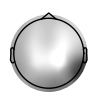

In [5]:
epoch_idx = 10
band_idx = 3

im, _ = mne.viz.plot_topomap(epochs_bandpower_data[epoch_idx, band_idx, :], epochs.info, 
                             sensors=False, contours=False, cmap='gray', show=True, 
                             outlines='head', res=32, extrapolate='head'
                            )

### STEP 4: EEG epochs (topomap image) --> EEG epochs (topomap image) numpy array

In [6]:
from utils.topomaps import _img_to_array, _remove_head_cartoon
from matplotlib import pyplot as plt

num_epochs = len(epochs_bandpower_data)
epochs_topomap_images = np.zeros((num_epochs, 5, 100, 100))

for epoch_idx in range(num_epochs):
    for band_idx in range(5):

        im, _ = mne.viz.plot_topomap(epochs_bandpower_data[epoch_idx, band_idx, :], epochs.info, 
                                     sensors=False, contours=False, cmap='gray', show=True, 
                                     outlines='head', res=32, extrapolate='head')

        fig_arr = _img_to_array(im)
    #     print(fig_arr.shape)

        clean_fig_arr = _remove_head_cartoon(fig_arr)
    #     print(clean_fig_arr.shape)

        grayscale = clean_fig_arr[:,:,0] / 255.0
    #     print(grayscale.shape)

        epochs_topomap_images[epoch_idx, band_idx, :, :] = grayscale
        
    plt.close('all')

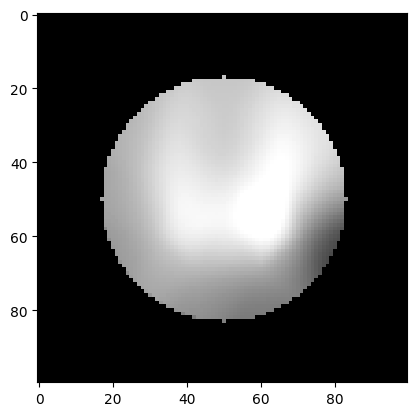

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

# same as previous plot above
epoch_idx = 10
band_idx = 3

plt.imshow(epochs_topomap_images[epoch_idx, band_idx, :, :], interpolation='nearest', cmap='gray')
plt.show()

### STEP 5: (...... use topomap images in PyTorch dataloader for model training)

In [8]:
# TODO